# Cleaning

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import pycountry
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import numpy as np
import seaborn as sn

from sklearn.preprocessing import normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from collections import Counter

plt.style.use('seaborn-deep')
%matplotlib inline 

/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
countryhappy = pd.read_csv('countryhappy.csv')
indiv = pd.read_csv('indiv.csv')
instance =  pd.read_csv('indivhappy.csv')

In [3]:
#join the happy moments and demographic based on 'wid' column 
indivhappy =pd.merge(indiv, instance, on='wid')

In [4]:
#rename the country column in indiv happy into countrycode
indivhappy =indivhappy.rename(columns = {'country':'countrycode'})

In [5]:
#drop all the na value in indivhappy dataframe
indivhappy = indivhappy.dropna()

In [6]:
#indivhappy is a dataframe of each individual describing happy moments with demographic info 
indivhappy.head()

,wid,age,countrycode,gender,marital,parenthood,hmid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
1,1,37.0,USA,m,married,y,28054,24h,My mother called out of the blue to tell me ho...,My mother called out of the blue to tell me ho...,True,1,affection,affection
35,1,37.0,USA,m,married,y,57637,24h,I got to take the day off from my part time jo...,I got to take the day off from my part time jo...,True,1,affection,affection
38,1,37.0,USA,m,married,y,64498,3m,my son had a great time on his 8th birthday.,my son had a great time on his 8th birthday.,True,1,affection,affection
46,1,37.0,USA,m,married,y,80306,3m,I got to have a three day weekend which i spen...,I got to have a three day weekend which i spen...,True,1,affection,affection
51,1,37.0,USA,m,married,y,88307,3m,My fiance proposed to me in front of my family...,My fiance proposed to me in front of my family...,True,1,affection,affection


In [7]:
indivhappy.countrycode.unique()

array(['USA', 'IND', 'VNM', 'THA', 'GBR', 'SRB', 'BGR', 'BRA', 'BGD',
       'CAN', 'PRT', 'PHL', 'VEN', 'MKD', 'DOM', 'DNK', 'IDN', 'AUS',
       'URY', 'JAM', 'EGY', 'DEU', 'KEN', 'MDA', 'IRL', 'NGA', 'ALB',
       'MEX', 'TTO', 'KWT', 'RUS', 'LTU', 'PRI', 'SWE', 'PER', 'PAK',
       'TUR', 'FRA', 'ARE', 'COL', 'ROU', 'ARM', 'MAC', 'SGP', 'UGA',
       'NIC', 'JPN', 'GRC', 'TWN', 'FIN', 'GHA', 'NZL', 'NLD', 'ITA',
       'AUT', 'LKA', 'KNA', 'POL', 'DZA', 'GMB', 'ASM', 'CZE', 'MLT',
       'SVN', 'ZAF', 'ECU', 'CHL', 'LVA', 'ESP', 'NOR', 'MYS', 'CRI',
       'UMI', 'ETH', 'TCA', 'BHS', 'ARG', 'GTM', 'HRV', 'BEL', 'EST',
       'AFG', 'CYP', 'ISL'], dtype=object)

In [8]:
countryhappy.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [9]:
#now we need to join the countryhappy dataframe and indivhappy dataframe by coutrycode 
#to do that we need to look up the country code by country name using pycountry library

codelist = []
for i in list(countryhappy['Country']):
    try:
        code = pycountry.countries.get(name= i).alpha_3
        codelist.append(code)
    except:#when the country is not in pycountry, append the name of the country
        codelist.append(i)

In [10]:
#some of the country names are different in pycountry library and data.. so replacing them manually here..
l1 = [i.replace('Czech Republic','CZE') for i in codelist ]
l2 = [i.replace('Taiwan Province of China','CHN') for i in l1 ]
l3 = [i.replace('Russia','RUS') for i in l2 ]
l4 = [i.replace('South Korea','KOR') for i in l3 ]
l5 = [i.replace('Moldova','MDA') for i in l4 ]
l6 = [i.replace('Bolivia','BOL') for i in l5 ]
l7 = [i.replace('Hong Kong S.A.R., China','CHN') for i in l6]
l8 = [i.replace('Venezuela','VEN') for i in l7 ]
l9 = [i.replace('Macedonia','MKD') for i in l8 ]
l10 = [i.replace('Vietnam','VNM') for i in l9 ]
l11 = [i.replace('Palestinian Territories','PSE') for i in l10]
l12 = [i.replace('Ivory Coast','CIV') for i in l11 ]
l13 = [i.replace('Syria','SYR') for i in l12 ]
codelist = [i.replace('Tanzania','TZA') for i in l13 ]
#yep I know this is a silly way to do it.. but we have a our country code list here! 

In [11]:
#convert country code list into pandas series object, and add it to countryhappy dataframe 
codelist = pd.Series(codelist)
countryhappy['countrycode'] = codelist.values

In [12]:
#join two dataframe on countrycode, finished first round of data cleaning! 
df =pd.merge(countryhappy, indivhappy, on = 'countrycode')
df.columns

Index(['Country', 'Happiness.Rank', 'Happiness.Score', 'Whisker.high',
       'Whisker.low', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.', 'Dystopia.Residual', 'countrycode',
       'wid', 'age', 'gender', 'marital', 'parenthood', 'hmid',
       'reflection_period', 'original_hm', 'cleaned_hm', 'modified',
       'num_sentence', 'ground_truth_category', 'predicted_category'],
      dtype='object')

# EDA

Text(0.5,1,'emotion count')

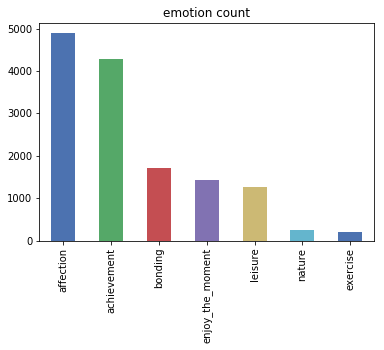

In [13]:
#what's the ranks of emotion that makes people happy
(df['predicted_category'].value_counts()).plot(kind = 'bar')
plt.title('emotion count')

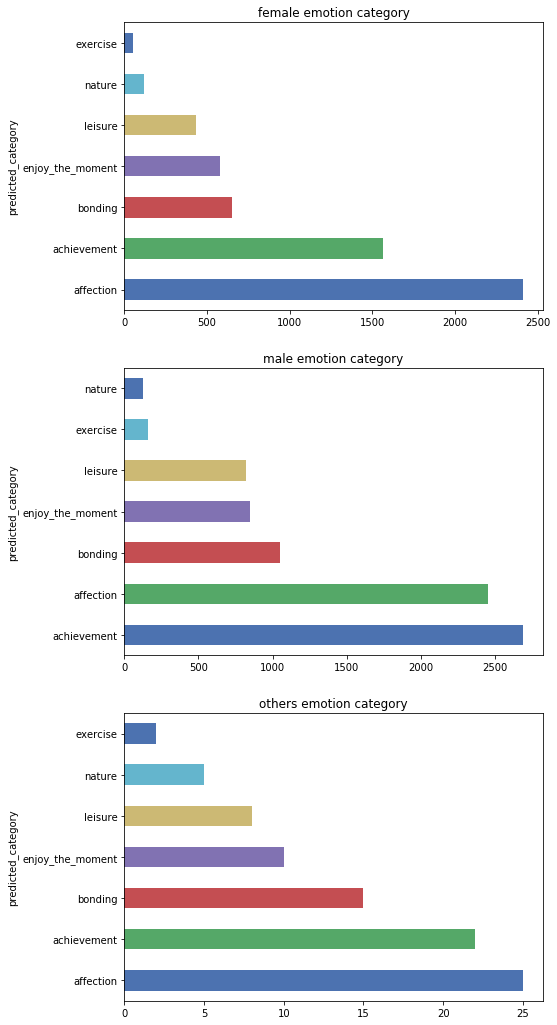

In [17]:
#looking at individual's happiness by gender
bygender = df.groupby('gender')['predicted_category'].value_counts()
bygender

_, ax = plt.subplots(3,1,figsize=(7.5,18))

bygender.loc['f'].plot(x='index', kind='barh', ax=ax[0], title = 'female emotion category')
bygender.loc['m'].plot(x='index', kind='barh', ax=ax[1], title = 'male emotion category')
bygender.loc['o'].plot(x='index', kind='barh', ax=ax[2], title = 'others emotion category')

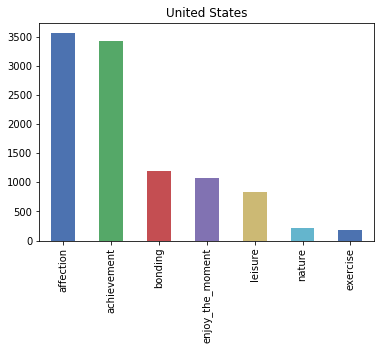

In [18]:
df[df['Country'] == 'United States']['predicted_category'].value_counts().plot(kind = 'bar', title = 'United States')


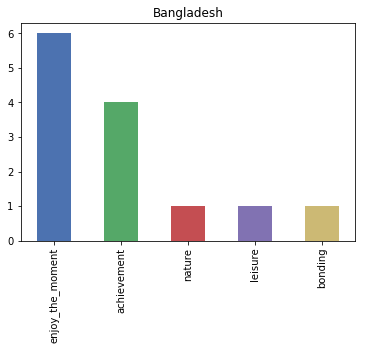

In [19]:
df[df['Country'] == 'Bangladesh']['predicted_category'].value_counts().plot(kind = 'bar', title = 'Bangladesh')

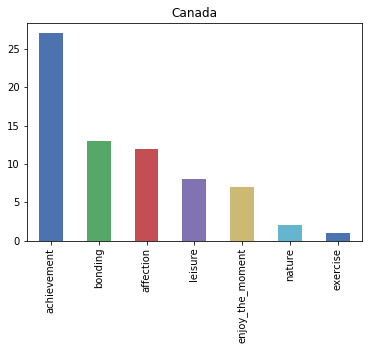

In [20]:
df[df['Country'] == 'Canada']['predicted_category'].value_counts().plot(kind = 'bar', title = 'Canada')

In [21]:
#visualizing country's happiness on global map
data = dict(type = 'choropleth', 
           locations = countryhappy['Country'],
           locationmode = 'country names',
           z = countryhappy['Happiness.Rank'], 
           text = countryhappy['Country'],
           colorbar = {'title':'Happiness Rank'})
layout = dict(title = 'Global CountryHappiness', 
             geo = dict(showframe = False, 
                       projection = {'type': 'Mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

# more cleaning

In [22]:
#cleaning the column names for caps, . and _
df.columns =df.columns.str.replace('[^A-Za-z\s]+','')
df.columns= df.columns.str.lower()


#convert gender(female 1), marital(married 1), parental(have kids 1) status to 0,1
df1 =df.replace (['f','m','o','married','single','divorced','separated','widowed','y','n','prefer not to say','čá'],[1,0,0,1,0,0,0,0,1,0,28,28])
df = df.replace(['y','n'],[1,0])
df1.head()

,country,happinessrank,happinessscore,whiskerhigh,whiskerlow,economygdppercapita,family,healthlifeexpectancy,freedom,generosity,...,marital,parenthood,hmid,reflectionperiod,originalhm,cleanedhm,modified,numsentence,groundtruthcategory,predictedcategory
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,...,1,0,113190,24h,I played an app design game and received a per...,I played an app design game and received a per...,True,1,achievement,achievement
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,...,1,0,27676,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
2,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,...,1,0,49534,24h,I bought my wedding shoes!,I bought my wedding shoes!,True,1,achievement,achievement
3,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,...,1,0,52451,24h,My new watch arrived in the mail!,My new watch arrived in the mail!,True,1,achievement,achievement
4,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,...,1,0,84125,3m,We watched Rocky Horror Picture Show for the f...,We watched Rocky Horror Picture Show for the f...,True,1,leisure,leisure


# Base model


In [23]:
from sklearn.metrics import accuracy_score, classification_report

In [24]:
y = df1['predictedcategory']
X  = df1[['happinessscore','economygdppercapita', 'family', 'healthlifeexpectancy',
       'freedom', 'generosity', 'trustgovernmentcorruption','age', 'gender', 'marital',
       'parenthood']]
X_train1,X_test1,y_train1,y_test1 = train_test_split(X,y, test_size = 0.3)

In [25]:
#build a dataframe that stores the confusion matrix for data for different models 

def scorematrix(X_train,y_train,X_test,y_test):
    models = [RandomForestClassifier(), GaussianNB(), SVC(class_weight = 'balanced'), KNeighborsClassifier(), LogisticRegression()]
    modelnames = ['RandomForest', 'GaussianNB','SVC','Kneighbors','LogisticRegression']

    scorenames = ['precision','recall','f1','accuracy']
    precision = []
    recall =[]
    f1 = []
    accuracy = []

    for model in models:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        precision.append(precision_score(y_test,y_pred, average = 'weighted'))
        recall.append(recall_score(y_test,y_pred,average = 'weighted'))
        f1.append(f1_score(y_test,y_pred,average = 'weighted'))
        accuracy.append(accuracy_score(y_test,y_pred))

    scores_df = pd.DataFrame({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy})
    scores_df.set_index([modelnames], inplace = True)

    return scores_df

In [26]:
scorematrix(X_train1,y_train1,X_test1,y_test1)

/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



,accuracy,f1,precision,recall
RandomForest,0.397293,0.354089,0.376417,0.397293
GaussianNB,0.225362,0.231268,0.293764,0.225362
SVC,0.197103,0.234951,0.358092,0.197103
Kneighbors,0.348373,0.317627,0.318574,0.348373
LogisticRegression,0.393256,0.308983,0.254455,0.393256


# Improve my model
1. add features(vectorized text) 2. resampling data 3. gridsearch(optimize my parameters)


1. add vectorized text 

In [27]:
#convert the cleanedhm column text into 100 additional features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

vectorizer = CountVectorizer()
newf = vectorizer.fit_transform(df['cleanedhm'])
newf2 = NMF(n_components = 100)
nmf_mat=newf2.fit_transform(newf)#create topics

In [28]:
newf2.components_
vecfeatures =vectorizer.get_feature_names()

In [29]:
#extract vectorized top topics in words
def toptopics(model, feature_names, n_top_words):
    toptopics = {}
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
        toptopics[topic_idx] = ([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return toptopics

In [30]:
#a list of topics for feature importance reference
toptopics = toptopics(newf2,vecfeatures,10)

In [42]:
#some top topics that makes people happy
print(toptopics[1])
print(toptopics[2])
print(toptopics[3])

['my', 'husband', 'mom', 'favorite', 'dog', 'dad', 'girlfriend', 'office', 'boss', 'cat']
['the', 'same', 'by', 'way', 'park', 'weather', 'sun', 'also', 'took', 'around']
['and', 'other', 'joy', 'both', 'sit', 'healthy', 'spring', 'children', 'took', 'neighbor']


In [43]:
#append vectorized feature into original dataframe
dfnewf2 = pd.DataFrame(nmf_mat)
df2 = df1.merge(dfnewf2, left_index=True, right_index=True)

In [44]:
X =df2.drop(['happinessrank','whiskerhigh','whiskerlow','dystopiaresidual', 'country','countrycode', 'wid',
         'hmid', 'reflectionperiod', 'originalhm', 'cleanedhm','modified', 'numsentence', 'groundtruthcategory'
         ,'predictedcategory'], axis = 1)
y = df2.predictedcategory

X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y ,test_size = 0.3)

In [45]:
#scorematrix after adding word vectors as features
#1.vectorized text boosted our score 
#2.random forest boosted the accuracy score
scorematrix(X_train,y_train,X_test,y_test)

/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



,accuracy,f1,precision,recall
RandomForest,0.764664,0.748757,0.762928,0.764664
GaussianNB,0.354548,0.392170,0.607941,0.354548
SVC,0.168606,0.196015,0.320650,0.168606
Kneighbors,0.459273,0.437683,0.445765,0.459273
LogisticRegression,0.578010,0.514822,0.595667,0.578010


In [32]:
#based on the score matrix above we will proceed with the random forest model 
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred =rf.predict(X_train)
print (accuracy_score(y_train,y_pred))
y_pred =rf.predict(X_test)
print (accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
print()

0.9923656351791531
0.760389456186179
                  precision    recall  f1-score   support

     achievement       0.70      0.84      0.76      1282
       affection       0.80      0.91      0.85      1466
         bonding       0.92      0.79      0.85       514
enjoy_the_moment       0.62      0.39      0.47       431
        exercise       0.73      0.17      0.28        64
         leisure       0.76      0.55      0.64       379
          nature       0.55      0.08      0.14        75

     avg / total       0.76      0.76      0.74      4211




2.SMOTE - sampling

In [33]:
#!pip install kmeans-smote
from imblearn.over_sampling import SMOTE

In [34]:
smote = SMOTE(kind = "regular")
X_smtrain, y_smtrain = smote.fit_sample(X_train, y_train)

In [35]:
rf = RandomForestClassifier()
rf.fit(X_smtrain,y_smtrain)
y_pred =rf.predict(X_smtrain)
print (accuracy_score(y_smtrain,y_pred))
print (classification_report(y_smtrain, y_pred))
y_pred =rf.predict(X_test)
print (accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
print()

0.9978696741854637
                  precision    recall  f1-score   support

     achievement       0.99      1.00      1.00      3420
       affection       0.99      1.00      1.00      3420
         bonding       1.00      1.00      1.00      3420
enjoy_the_moment       1.00      1.00      1.00      3420
        exercise       1.00      1.00      1.00      3420
         leisure       1.00      1.00      1.00      3420
          nature       1.00      1.00      1.00      3420

     avg / total       1.00      1.00      1.00     23940

0.7468534789836143
                  precision    recall  f1-score   support

     achievement       0.70      0.79      0.74      1282
       affection       0.83      0.85      0.84      1466
         bonding       0.88      0.83      0.86       514
enjoy_the_moment       0.50      0.49      0.49       431
        exercise       0.53      0.33      0.40        64
         leisure       0.76      0.59      0.66       379
          nature       0.37   

In [36]:
#scorematrix after adding word vectors as features
scorematrix(X_smtrain,y_smtrain,X_test,y_test)

,accuracy,f1,precision,recall
RandomForest,0.734980,0.729967,0.730024,0.734980
GaussianNB,0.414866,0.460982,0.633019,0.414866
SVC,0.225837,0.264072,0.346024,0.225837
Kneighbors,0.383519,0.406253,0.456102,0.383519
LogisticRegression,0.507955,0.545859,0.630944,0.507955


3.Tuning hyperparameters for my randomforest 

In [37]:
from sklearn.model_selection import RandomizedSearchCV

In [38]:
#tuning hyperparameters 
n_estimators = [int(x) for x in np.linspace(200,2000,10)]
max_features = ['auto','sqrt']
max_depths = [int(x) for x in np.linspace(10,110,10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1,2,4]
bootstrap = True

#create your random grid'
randomgrid  = {'n_estimators' :n_estimators,'max_features':max_features,'max_depths':max_depths,
               'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,
              'bootstrap':bootstrap}

In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 52.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=1,
          param_distributions={'min_samples_split': [2, 5, 10], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [41]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [42]:
import pickle 
with open('rf_bestparam.pkl','wb') as picklefile:
    pickle.dump(rf_random.best_params_,picklefile)   

In [43]:
#let's see the confusion matrix score after tuning
rf = RandomForestClassifier(bootstrap = False, max_depth=30, max_features = 'sqrt',
                           min_samples_leaf = 1, min_samples_split = 2, n_estimators =2000)
rf.fit(X_smtrain,y_smtrain)
y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

     achievement       0.77      0.86      0.81      1282
       affection       0.85      0.92      0.88      1466
         bonding       0.92      0.85      0.88       514
enjoy_the_moment       0.64      0.54      0.59       431
        exercise       0.91      0.31      0.47        64
         leisure       0.84      0.68      0.75       379
          nature       0.65      0.27      0.38        75

     avg / total       0.81      0.81      0.80      4211



# 4.Evaluation and Interpretation
1. confusion matrix  
2. feature importance

In [44]:
from sklearn.metrics import confusion_matrix 

In [45]:
cm = confusion_matrix(y_test,y_pred)
accuracy_score(y_test,y_pred)

0.810021372595583

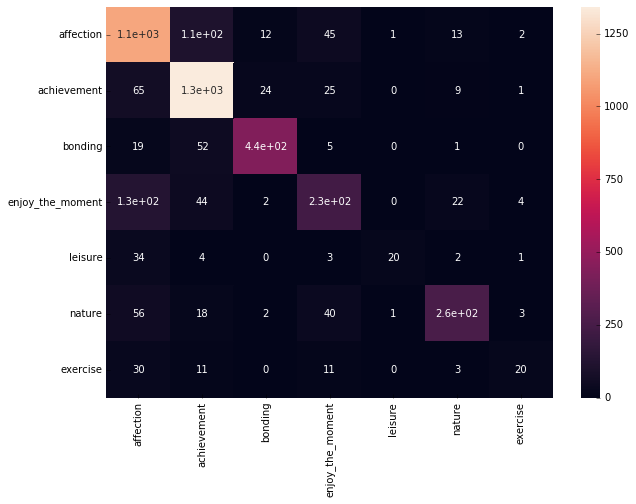

In [46]:
df_cm = pd.DataFrame(cm, index = ['affection','achievement','bonding','enjoy_the_moment','leisure','nature','exercise'],
                                 columns = ['affection','achievement','bonding','enjoy_the_moment','leisure','nature','exercise'])
plt.figure (figsize = (10,7))
sn.heatmap(df_cm,annot = True)

Feature importance

In [47]:
#let's take a look at the feature importance before adding vectorized text

In [48]:
rf.fit(X_train1,y_train1)
importances = rf.feature_importances_


([<matplotlib.axis.XTick at 0x124dae128>,
 <a list of 11 Text xticklabel objects>)

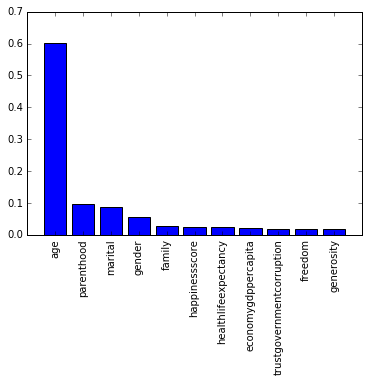

In [49]:
#feature importance before adding vectorized text
flist = sorted([(v, list(X_train1.columns)[i]) for i,v in enumerate(importances)],reverse=True)
fim1 = [i[0] for i in flist]
fname =[i[1] for i in flist]
plt.bar(np.linspace(1,11,11),fim1, align = 'center')
plt.xticks(np.linspace(1,11,11),fname, rotation =90)

In [50]:
#now let's take a look at the feature importance of the vectorized random forest model
rf.fit(X_smtrain,y_smtrain)
importances2 = rf.feature_importances_

In [51]:
#vectorized feature importance list
flist2 = sorted([(v, i) for i,v in enumerate(importances2)],reverse=True)
#after adding vectorization, it seems that the text features dominated the importance feature

In [53]:
#top ten most popular topics
vecindexlist = [i[1]-12 for i in flist2[:10]]
topvecfeatures=[]
for i in vecindexlist:
    topvecfeatures.append(toptopics[i])
    
for index, item in enumerate(topvecfeatures, start = 1):
    print(index, item)

1 ['after', 'long', 'months', 'years', 'met', 'being', 'waiting', 'meet', 'days', 'seeing']
2 ['to', 'going', 'do', 'go', 'decided', 'want', 'watch', 'take', 'eat', 'music']
3 ['all', 'are', 'members', 'together', 'there', 'always', 'll', 'passed', 'ceremony', 'organized']
4 ['wanted', 'just', 'life', 'as', 'grandma', 'really', 'her', 'has', 'did', 'years']
5 ['one', 'favorite', 'another', 'best', 'students', 'events', 'shows', 'little', 'couldn', 'over']
6 ['them', 'us', 'remember', 'never', 'if', 'wish', 'years', 'donat', 'florence', 'grandma']
7 ['a3i', 'moment', 'not', 'she', 'doing', 'but', 'proud', 'enough', 'saving', 'which']
8 ['my', 'mom', 'house', 'favorite', 'dog', 'dad', 'girlfriend', 'sister', 'office', 'best']
9 ['friend', 'best', 'old', 'party', 'mine', 'met', 'marriage', 'seen', 'who', 'talked']
10 ['which', 'few', 'there', 'other', 'blood', 'brought', 'quite', 'hours', 'needed', 'makes']


In [ ]:
#most insignificant features
# 1. ['in', 'life', 'seen', 'past', 'while', 'months', 'law', 'mail', 'well', 've']
# 2. ['so','much','excited','could','surprise','don','no','always','back','passed']
# 3. ['able', 'to', 'being', 'car', 'do', 'sleep', 'enjoy', 'pay', 'off', 'buy']
# 4. ['movement', 'happiest','person','as', 'time','completed','just','far','change','concerned']
# 5. ['at','restaurant','lunch','store','local','gym','won','looked','raise','there']


# Application

In [52]:
#let's try to use this model to predict donald trump's happy emotion category =
celeb = pd.read_csv('donaltrump exp.csv')
celeb.head()

,happinessscore,economygdppercapita,family,healthlifeexpectancy,freedom,generosity,trustgovernmentcorruption,age,gender,marital,parenthood,text
0,6.993,1.546259,1.419921,0.774287,0.505741,0.392579,0.135639,71,0,1,1,"Rep. Lou Barletta, a Great Republican from Pen..."
1,6.993,1.546259,1.419921,0.774287,0.505741,0.392579,0.135639,71,0,1,1,"In the “old days,” when good news was reported..."
2,6.993,1.546259,1.419921,0.774287,0.505741,0.392579,0.135639,71,0,1,1,Will be heading over shortly to make remarks a...
3,6.993,1.546259,1.419921,0.774287,0.505741,0.392579,0.135639,71,0,1,1,The Budget Agreement today is so important for...
4,6.993,1.546259,1.419921,0.774287,0.505741,0.392579,0.135639,71,0,1,1,"Representative Devin Nunes, a man of tremendou..."


In [53]:
vectorizer = CountVectorizer()
newf = vectorizer.fit_transform(celeb['text '])
newf2 = NMF(n_components = 100)
nmf_mat=newf2.fit_transform(newf)#create topics

newf2.components_
vecfeatures =vectorizer.get_feature_names()

def toptopics(model, feature_names, n_top_words):
    toptopics = {}
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
        toptopics[topic_idx] = ([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return toptopics

toptopics = toptopics(newf2,vecfeatures,10)


dfnewf2 = pd.DataFrame(nmf_mat)
#append my vectorized word df into df1 to get my features
df2 = celeb.merge(dfnewf2, left_index=True, right_index=True)
df2.drop('text ', axis = 1, inplace = True)
X_test = df2
y_pred = rf.predict(X_test)
Counter(list(y_pred))

Counter({'achievement': 72,
         'affection': 12,
         'bonding': 4,
         'enjoy_the_moment': 9,
         'leisure': 3})

In [56]:
#let's take a look at the topic topics that makes Trump happy
rf.fit(X_test, y_pred)
importance = rf.feature_importances_ 
flist2 = sorted([(v, i) for i,v in enumerate(importance)],reverse=True)
vecindexlist = [i[1]-12 for i in flist2[:10]]
topvecfeatures=[]
for i in vecindexlist:
    topvecfeatures.append(toptopics[i])
    
for index, item in enumerate(topvecfeatures, start = 1):
    print(index, item)

1 ['to', 'in', 'rick', 'will', 'be', 'give', 'continue', 'congress', 'already', 'saccone']
2 ['that', 'the', 'you', 'people', 'president', 'history', 'regulation', 've', 'wrote', 'stories']
3 ['president', 'is', 'wow', 'badly', 'treated', 'obama', 'just', 'brother', 'malik', 'probably']
4 ['the', 'good', 'and', 'in', 'of', 'about', 'rate', 'all', 'news', 'numbers']
5 ['russia', 'after', 'rising', 'fact', 'despite', 'them', 'wages', 'nobody', 'year', 'numbers']
6 ['that', 'we', 'have', 'are', 'wall', 'than', 'far', 'mountains', 'violent', 'rivers']
7 ['at', 'foxnews', '10', 'ingrahamangle', 'interviewed', '00', 'will', 'by', 'enjoy', 'be']
8 ['to', 'over', 'all', 'the', 'and', 'day', 'in', 'now', 'get', 'beautiful']
9 ['in', 'at', 'from', 'saw', 'nyc', 'saturday', 'singing', 'awesome', 'ayrshire', 'club']
10 ['that', 'to', 'news', 'pence', 'mate', 'chosen', '11', 'governor', 'vice', 'mike']
